In [1]:
from tasks import preprocessing, util

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os

2024-02-16 19:30:58.572593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 19:30:58.572632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 19:30:58.574614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 19:30:58.588782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 19:31:00.731894: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [3]:
print("Loading training dataset...")
train_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-train.conllu")
print("Loading validation dataset...")
val_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-dev.conllu")
print("Loading test dataset...")
test_df = preprocessing.conllu_to_pd("input/UD_English-EWT/en_ewt-ud-test.conllu")

print(f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
      "\nTest data shape: {test_df.shape}")

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [4]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [5]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [6]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [7]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [8]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [9]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figured saved to output/ex_2_dataset_stats.png


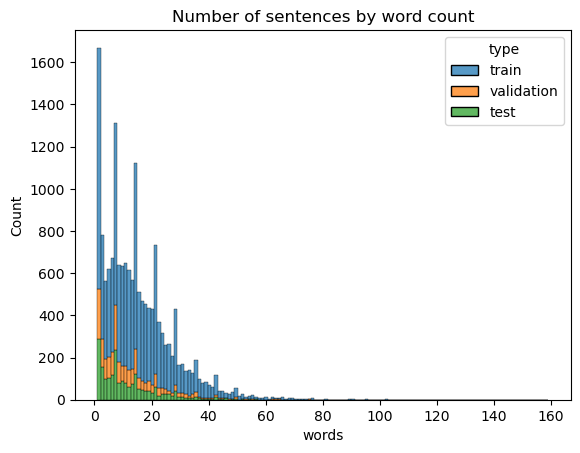

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

In [11]:
train_length.describe()

count    12544.000000
mean        16.311703
std         12.404826
min          1.000000
25%          7.000000
50%         14.000000
75%         23.000000
max        159.000000
Name: words, dtype: float64

In [12]:
val_length.describe()

count    2001.000000
mean       12.569715
std        10.419274
min         1.000000
25%         5.000000
50%        10.000000
75%        17.000000
max        75.000000
Name: words, dtype: float64

In [13]:
test_length.describe()

count    2077.000000
mean       12.082812
std        10.607005
min         1.000000
25%         4.000000
50%         9.000000
75%        17.000000
max        81.000000
Name: words, dtype: float64

In [14]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 16654


In [15]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 204614
Validation: 25152
Testing: 25096


In [16]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 12544
Validation: 2001
Testing: 2077


## Baseline Model

In [17]:
from tasks.models import BaselineLabelClassifier


x_base_train = train_df.words
x_base_valid = val_df.words
x_base_test = test_df.words

y_base_train = train_df.pos
y_base_valid = val_df.pos
y_base_test = test_df.pos

base_cls = BaselineLabelClassifier()
base_cls.fit(X=x_base_train, y=y_base_train)

BaselineLabelClassifier()

In [18]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(x_base_train)
print(classification_report(y_base_train, training_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     13152
         ADP       0.87      0.67      0.76     17795
         ADV       0.61      0.83      0.71     10113
         AUX       0.88      0.79      0.83     12828
       CCONJ       0.98      0.99      0.99      6688
         DET       0.96      0.95      0.95     16299
        INTJ       0.68      0.87      0.76       693
        NOUN       0.88      0.90      0.89     34813
         NUM       0.99      0.89      0.94      4126
        PART       0.71      0.89      0.79      5748
        PRON       0.90      0.95      0.93     18642
       PROPN       0.90      0.84      0.87     12325
       PUNCT       0.99      0.99      0.99     23597
       SCONJ       0.64      0.41      0.50      3839
         SYM       0.88      0.83      0.85       721
        VERB       0.83      0.89      0.86     22594
           X       0.86      0.64      0.74       641

    accuracy              

In [19]:
test_preds = base_cls.predict(x_base_test)
print(classification_report(y_base_test, test_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.83      0.85      1787
         ADP       0.89      0.67      0.76      2033
         ADV       0.62      0.83      0.71      1178
         AUX       0.89      0.78      0.83      1543
       CCONJ       0.99      0.99      0.99       737
         DET       0.96      0.95      0.95      1897
        INTJ       0.70      0.72      0.71       120
        NOUN       0.66      0.89      0.76      4137
         NUM       0.96      0.54      0.69       542
        PART       0.70      0.90      0.79       649
        PRON       0.91      0.95      0.93      2162
       PROPN       0.88      0.48      0.62      1980
       PUNCT       1.00      0.98      0.99      3096
       SCONJ       0.60      0.44      0.51       384
         SYM       0.81      0.83      0.82       109
        VERB       0.80      0.83      0.81      2606
           X       0.00      0.00      0.00       136

    accuracy              

In [20]:
del base_cls

## MLP Classifier

In [21]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [22]:
MIN_SENTENCE_LENGTH = 5
WINDOW_SIZE = 5
# training data are used exclusively for training accuracy, thus 
# we only need a small, representative sample
TRAINING_LIM = 25000
VALID_LIM = 25000
TEST_LIM = 10000
SEED = 42
PAD_TOKEN = "<PAD>"

In [23]:
train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_filt = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


In [24]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, GRU,\
                                    TextVectorization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelBinarizer

In [25]:
# download and unzip only if the download and unzipped files do not exist 
!wget -nc -P input/fasttext https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

![ -f "input/fasttext/cc.en.300.bin" ] && echo "Skipping model file" || gzip --decompress --keep --force "input/fasttext/cc.en.300.bin.gz"   

File ‘input/fasttext/cc.en.300.bin.gz’ already there; not retrieving.

Skipping model file


In [26]:
import fasttext 


print("Loading embedding model...")
fasttext_model = fasttext.load_model('input/fasttext/cc.en.300.bin')

Loading embedding model...


In [27]:
(
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
    lb_mlp,
) = preprocessing.mlp_input(
    train_df_filt,
    val_df_filt,
    test_df_filt,
    embed_model=fasttext_model,
    intermediate_dir=INTERMEDIATE_DIR,
    train_lim=TRAINING_LIM,
    val_lim=VALID_LIM,
    test_lim=TEST_LIM,
    window_size=WINDOW_SIZE,
    seed=SEED,
    pad_token=PAD_TOKEN,
)


del fasttext_model

Attempting to load intermediate calculations...
Loaded cached calculations.


In [28]:
mlp = keras.saving.load_model(os.path.join(INPUT_DIR, "model.keras"))

train_preds_mlp = mlp.predict(x_train_mlp)
val_preds_mlp = mlp.predict(x_valid_mlp)
test_preds_mlp = mlp.predict(x_test_mlp)

2024-02-16 19:32:17.994882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 19:32:18.376458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 19:32:18.376832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

313/313 [==============================] - 2s 5ms/step


## Creating the RNN model

### Vectorization

In [29]:
lb = LabelBinarizer()

y_train = lb.fit_transform(train_df.pos)
y_valid = lb.transform(val_df.pos)
y_test = lb.transform(test_df.pos)


In [30]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.95))
MAX_SEQUENCE_LENGTH

39

In [31]:
MAX_WORDS = vocab_size
EMBEDDING_DIM = 300

In [32]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1, 
              output_sequence_length=MAX_SEQUENCE_LENGTH)

print("Setting up vectorizer...")
vectorizer.adapt(train_df.words.values)

Setting up vectorizer...


### Word embeddings

In [33]:
gpus = tf.config.list_physical_devices('GPU')
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

Executing with  /physical_device:GPU:0


In [34]:
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

print("Loading embedding model...")
fasttext_model = fasttext.load_model('input/fasttext/cc.en.300.bin')

print("Computing word embeddings...")
for w2idx, _word in tqdm(enumerate(vectorizer.get_vocabulary()), 
                          total = len(vectorizer.get_vocabulary())):
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

# reclaim memory
del fasttext_model

Loading embedding model...
Computing word embeddings...


  0%|          | 0/16251 [00:00<?, ?it/s]

(https://arxiv.org/pdf/1801.05134.pdf)

In [35]:
GRU_SIZE = 300
DENSE = 1000


# create empty sequential model
model = tf.keras.Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
model.add(LayerNormalization())

model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False)))
model.add(LayerNormalization())

# add an MLP with 1 hidden layer
model.add(Dense(units=DENSE, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(len(np.unique(train_df.pos)), activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 39, 300)           4996200   
                                                                 
 bidirectional (Bidirection  (None, 39, 600)           1083600   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 39, 600)           1200      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 600)               1623600   
 onal)                                                  

In [42]:
import keras_tuner as kt


def tune_self_attention_gru(
    hp: kt.HyperParameters,
    input_layers: list[tf.keras.layers.Layer],
    output_size: int,
    bidirect_num_min: int,
    bidirect_num_max: int,
    metrics: list,
    loss: str,
    gru_size: int=300
) -> keras.Model:
    model = tf.keras.Sequential()

    # sanity checks
    assert (
        bidirect_num_min <= bidirect_num_max
    ), "bidirect_num_min must be less or equal to bidirect_num_max"

    # bidirectional GRUs
    for layer in input_layers:
        model.add(layer)
    
    use_layer_norm = hp.Boolean("use_layer_norm")
    variational_dropout = hp.Choice("variational_dropout", [0., 0.33])

    # don't mix both
    if use_layer_norm:
        variational_dropout = 0

    for _ in range(hp.Int(name="num_layers", 
                          min_value=bidirect_num_min,
                          max_value=bidirect_num_max)- 1):
        model.add(Bidirectional(GRU(gru_size, return_sequences=True, recurrent_dropout=variational_dropout)))

        if use_layer_norm:
            model.add(LayerNormalization())
        else:
            model.add(Dropout(0.33))

    model.add(Bidirectional(GRU(gru_size, return_sequences=False, recurrent_dropout=variational_dropout)))

    # MLP (TODO: turn into self attention)
    model.add(Dense(units=DENSE, activation="tanh"))
    model.add(Dropout(0.5))

    # output layer
    if output_size == 1:
        model.add(Dense(output_size, activation="sigmoid"))
    else:
        model.add(Dense(output_size, activation="softmax"))

    # model compilation
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=hp_learning_rate),
        metrics=metrics,
    )

    return model

In [43]:
def search_pos_rnn(hp: kt.HyperParameters):
    input_layers = [
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Embedding(
            MAX_WORDS,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            mask_zero=True,
            trainable=False,
        ),
    ]

    return tune_self_attention_gru(
        hp,
        input_layers=input_layers,
        output_size=len(np.unique(train_df.pos)),
        bidirect_num_min=1,
        bidirect_num_max=2,
        metrics=["categorical_accuracy"],
        loss="categorical_crossentropy",
    )


tuner = kt.RandomSearch(
    search_pos_rnn,
    objective=kt.Objective("val_categorical_accuracy", direction="max"),
    max_trials=2,
    directory="KT_dir",
    project_name="KT_pos",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
use_layer_norm (Boolean)
{'default': False, 'conditions': []}
variational_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.33], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [44]:
# do not save weights to save time, just pick the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
train_data = train_df.words.values
val_data = val_df.words.values

tuner.search(train_data,
             y_train,
             validation_data=(val_data, y_valid), 
             epochs=10, 
             batch_size=256, # large batch size to fit more calculations
             callbacks=[early_stopping])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |False             |use_layer_norm
0.33              |0.33              |variational_dropout
2                 |2                 |num_layers
0.0001            |0.0001            |learning_rate

Epoch 1/10


2024-02-16 19:38:43.844150: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb3b8474480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 19:38:43.844182: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2024-02-16 19:38:43.919173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 19:38:44.041323: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708105124.305707   81451 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 622s 744ms/step - loss: 0.9635 - categorical_accuracy: 0.7435 - val_loss: 0.5708 - val_categorical_accuracy: 0.8322
Epoch 2/10
800/800 [==============================] - 561s 701ms/step - loss: 0.4516 - categorical_accuracy: 0.8669 - val_loss: 0.5156 - val_categorical_accuracy: 0.8472
Epoch 3/10
485/800 [=================>............] - ETA: 3:19 - loss: 0.4126 - categorical_accuracy: 0.8752